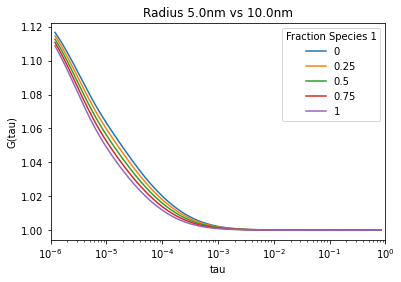

175.49705455247624 350.9941091049525 8.46314482481144e-11 4.23157241240572e-11 0.0010143270293179693


In [1]:
# %%timeit
# %lprun
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
from scipy.constants import pi
from scipy.constants import k as kb
import csv

#import data so i have a lag time array to use
testdata=pd.read_csv('200425_40nm_A647_6_avg_w_std_dev.txt', sep='\t', header=0)  #read in tab seperated txt file
testdata=testdata.rename(columns={"Lag Time (s)": "tau", "Correlation  ": "g_tau"})  #rename columns
testdata['tau']=pd.to_numeric(testdata['tau'])  #convert imported data to number format
testdata['g_tau']=pd.to_numeric(testdata['g_tau'])  #convert imported to number format
testdata['Std Dev']=pd.to_numeric(testdata['Std Dev'])
testdata.dropna(inplace=True)  #drops any Not a Number rows NaN. 
#truncate data subtracting out <1.2us
data_truncated = testdata[testdata['tau'] >= 1.2 *10**-6] 
#data_truncated.plot(kind='scatter', x='tau', y='g_tau')


"""
G(tau)=G_diff(tau)*G_trip(tau)
G_diff=f1**2 * g_1(tau) + f2**2 * g_2(tau) + ... where 1=Sum(fi) so for a two component system f2=1-f1
g_i(tau)=1/N *(1/(1+tau/tau_D)*1/(sqrt(1+s*tau/tau_D)))

G_trip(tau)=1+T(1-T)*e**(tau/tau_trip)


Fit parameters: tau_D, s, N, T, tau_trip, (if two component, tau_D2 and f1)
s can be fixed to 5 or 7 NOTE though that they are using 1/s in the G_diff functional form 
this is stated in the basic FCS zeiss recommendation manual. No idea where that number comes from.  for now let vary free
additionally they have an alpha anomaly factor that idk where it comes from.
"""

# G(Tau) w 2-component diffusion and triplet state 
def auto_correlation_2c(tau, tau_D1, tau_D2, f1, s, N, T, tau_trip):
    G_diff1=1/N *(1/(1+tau/tau_D1))*(1/(np.sqrt(1+(s**2)*tau/tau_D1)))
    G_diff2=1/N *(1/(1+tau/tau_D2))*(1/(np.sqrt(1+(s**2)*tau/tau_D2)))
    G_trip=1+T/(1-T)*np.exp(-tau/tau_trip)
    G_tau=1+(f1*G_diff1 + (1-f1)*G_diff2)*G_trip
    return G_tau
#is tau_trip known/estimated for A647?  check empirical data

#Stokes Einstein Relationship
#D=kb*Temp/(6pi * eta * r) , kb=boltzman constant, T=temp, eta=dynamic viscosity, r=radius
#Typically we calculate D from tau_D but in this case will calculate tau_D from D
#tau_D=omega^2/4*D  get omega estimate from empiracal data for PBS and serum
#so design of script will be choose two radii -> calculate respective tau_D1 and tau_D2 simulate various mixture ratios use ratio to calculate N
#test effect of N as well?  what is a normal N look like?


# Define Buffer/Matrix Properties
Temp=293  #kelvin
viscosity_pbs=0.00166857949052026*math.exp(1878.13233998426/Temp)*10**-3 #Viscosity of PBS
viscosity_serum=0.0035705587930264*math.exp(1822.37546953649/Temp)*10**-3 #Viscosity of serum



#Empirical estimates of confocal volume
omega_PBS=2.4374224*10**-7 
omega_Serum=2.7619016*10**-7


#Define particle properties
r_1=5*10**-9 #m radius 1
r_2=10*10**-9 #m radius 2
D_1=kb*Temp/(6*pi*viscosity_pbs*r_1/2)
D_2=kb*Temp/(6*pi*viscosity_pbs*r_2/2)
tau_D1=omega_PBS**2 / (4*D_1)
tau_D2=omega_PBS**2 / (4*D_2)

#Estimates for triplet state
T=0.3 #estimated triplet state fraction
tau_trip=2.5*10**-6 #us


#initialization parameters
s=7 #structure parameter use recommended s=5 or 7
N=10
f1=[0, 0.25, 0.5, 0.75, 1]
xdata=list(data_truncated['tau'])
csv_export_df=pd.DataFrame({'Tau':xdata})
for i in f1:
    f1_param=i
    plt.plot(data_truncated['tau'], auto_correlation_2c(data_truncated['tau'], tau_D1, tau_D2, f1_param, s, N, T, tau_trip), label=f1_param)
    filename='Radius_' + str(round(r_1*10**9)) + 'nm_vs_' + str(round(r_2*10**9)) + 'nm' + "_population_component_1_" + str(f1)
    ydata=list(auto_correlation_2c(data_truncated['tau'], tau_D1, tau_D2, f1_param, s, N, T, tau_trip))
    ydata_name='G(tau)_'+'population_comp1_' + str(f1_param)
    csv_export_df[ydata_name]=ydata
filename='Radius_' + str(round(r_1*10**9)) + 'nm_vs_' + str(round(r_2*10**9)) + 'nm'
csv_export_df.to_csv(filename, index=False)

#df.to_csv(r'Path where you want to store the exported CSV file\File Name.csv', index = False)  format for export


#     ydata=list(auto_correlation_2c(data_truncated['tau'], tau_D1, tau_D2, f1_param, s, N, T, tau_trip))
    
#     with open(filename, 'w', newline='') as f:
#     fieldnames=['Tau', 'G(tau)']
#     thewriter=csv.DictWriter(f, fieldnames=fieldnames)
#     thewriter.writeheader()
#     thewriter.writerow({'Tau':data_truncated['tau'], 'G(tau)':auto_correlation_2c(data_truncated['tau'], tau_D1, tau_D2, f1_param, s, N, T, tau_trip)})

#Convert plot to log X plot and add legend, axis labels, display plot
plot_name='Radius ' + str(round(r_1*10**9, 1)) + 'nm vs ' + str(round(r_2*10**9, 1)) + 'nm'
plt.title(plot_name)
plt.xlabel('tau')
plt.xscale('log')
plt.xlim(10**-6, 10**0)
plt.ylabel('G(tau)')
plt.legend(title="Fraction Species 1")
plt.show()
    
    
print(tau_D1*10**6,tau_D2*10**6, D_1, D_2, viscosity_pbs)

# filename='Radius_' + str(round(r_1*10**9)) + 'nm_vs_' + str(round(r_2*10**9)) + 'nm' + "_population_component_1_" + str(f1)
# # xdata=list(data_truncated['tau'])
# ydata=list(auto_correlation_2c(data_truncated['tau'], tau_D1, tau_D2, f1_param, s, N, T, tau_trip))
# ydata_name='G(tau)_'+'population_comp1_" + str(f1_param)
# csv_exprot_df=pd.DataFrame('Tau':xdata, ydata_name:ydata)

In [4]:
filename='Radius_' + str(round(r_1*10**9)) + 'nm_vs_' + str(round(r_2*10**9)) + 'nm'
print(filename)
type(filename)

Radius_5nm_vs_10nm


str

In [5]:
print(csv_export_df)

          Tau  G(tau)_population_comp1_0  G(tau)_population_comp1_0.25  \
0    0.000001                   1.116692                      1.114708   
1    0.000001                   1.113399                      1.111227   
2    0.000002                   1.110339                      1.108006   
3    0.000002                   1.107494                      1.105020   
4    0.000002                   1.104845                      1.102247   
..        ...                        ...                           ...   
150  0.629146                   1.000000                      1.000000   
151  0.681574                   1.000000                      1.000000   
152  0.734003                   1.000000                      1.000000   
153  0.786432                   1.000000                      1.000000   
154  0.838861                   1.000000                      1.000000   

     G(tau)_population_comp1_0.5  G(tau)_population_comp1_0.75  \
0                       1.112724             

In [12]:
#df.to_csv(r'Path where you want to store the exported CSV file\File Name.csv', index = False)
csv_export_df.to_csv(r'\\regeneron.regn.com\grpdata\tar\Development\ProBio\Personnel\ZRO\Temp Empower Files\Radius_5nm_vs_10nm.csv', index=False)